# Сборный проект 2. HR-Аналитика.
**Описание иследования:**
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

**Цель исследования:**

1. Построить модель, прогнозирующую уровень удовлетворенности сотрудников с метрикой SMAPE ≤ 15.\
2. Построить модель, прогнозирующую увольнение сотрудников, с метрикой ROC-AUC ≥ 0.91.
    
**Исходные данные:**

    HR-аналитики предоставили наборы данных.\
        1. Две тренировочные выборки, для двух задач описанных выше.\
        2. Входные признаки тестовой выборки(Одинаковые для двух задач)\
        3. Две тестовые выборки с различным целевым признаком.

**План проекта**

*Задача 1.*
1. [Загрузка бибилиотек, предварительный анализ признаков для первой задачи](#Загрузка-библиотек,-загрузка-данных,-предварительный-анализ-признаков.)
2. [Предобработка данных](#Предобработка-данных)
3. [Исследовательский анализ данных](#Исследовательский-анализ-данных)
4. [Корреляционный анализ признаков](#Проведем-корреляционный-анализ)
5. [Создание пайплайна и выбор лучше модели](#Пайплайны.)

*Задача 2.*
1. [Загрузка данных, и проведение предобработки данных.](#Загрузим-данные-и-проведем-предобработку-если-потребуется:)
2. [Исследовательский анализ](#Проведем-исследовательский-анализ-данных)
3. [Матрица кореляции для новых тренировочных данных](#Построим-матрицу-корреляции-для-тренировочных-данных.)
4. [Составление портрета уволившегося сотрудника](#Составим-портрет-уволившегося-сотрудника.)
5. [Создание пайплайна с новым признаком](#Добавим-новый-признак-на-основе-предсказаний-прошлой-задачи.)

**[Общий вывод и рекомендации для бизнеса](#Итоговые-выводы:)** 

## Задание. Предсказание уровня удовлетворённости сотрудника.

### Загрузка библиотек, загрузка данных, предварительный анализ признаков.

In [1]:
!pip install phik -q
!pip install shap -q
!pip install matplotlib==3.5.0 -q
!pip install scikit-learn==1.1.3 -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import phik
import shap

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier 

from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.preprocessing import ( StandardScaler, 
                                  OneHotEncoder, 
                                  OrdinalEncoder,
                                  MinMaxScaler )

from sklearn.inspection import permutation_importance

### Установим константы.

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузим и посмотрим на данные.

In [4]:
df_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test = pd.read_csv('/datasets/test_features.csv')
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [5]:
def data_info(data):
    display(data.head())
    data.info()
    display(data.describe().T)
    print('Кол-во пропусков:\n', data.isna().sum())
    print('Кол-во явных дубликатов:', data.duplicated().sum())

In [6]:
def data_miss(df):
    return pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm')

In [7]:
data_info(df_train)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


Кол-во пропусков:
 id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
Кол-во явных дубликатов: 0


In [8]:
data_miss(df_train)

,0
id,0.000000
dept,0.200000
level,0.100000
workload,0.000000
employment_years,0.000000
last_year_promo,0.000000
last_year_violations,0.000000
supervisor_evaluation,0.000000
salary,0.000000
job_satisfaction_rate,0.000000


In [9]:
data_info(X_test)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


Кол-во пропусков:
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
Кол-во явных дубликатов: 0


In [10]:
data_miss(X_test)

,0
id,0.000000
dept,0.100000
level,0.000000
workload,0.000000
employment_years,0.000000
last_year_promo,0.000000
last_year_violations,0.000000
supervisor_evaluation,0.000000
salary,0.000000


In [11]:
data_info(y_test)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


Кол-во пропусков:
 id                       0
job_satisfaction_rate    0
dtype: int64
Кол-во явных дубликатов: 0


In [12]:
data_miss(y_test)

,0
id,0.000000
job_satisfaction_rate,0.000000


### Вывод по загрузке и просмотру данных.
    1. В тренировачных данных, есть пропуски, обработаем их дальше в пайплайне
    2. В тестовых входных данных, так же есть пропуски, их так же обработаем в пайплайне.
    3. Явные дупликаты в данных так же отсутсвуют.
    4. Процент пропусков мал, заменим данные на NaN

### Предобработка данных

#### Посмотрим на уникальные значения в данных, для выявления опечаток.

In [13]:
def uniq_df(df):
    for i in df:
        print(i, df[i].unique())

In [14]:
uniq_df(df_train)

id [155278 653870 184592 ... 533318 706868 338347]
dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
employment_years [ 2  1  4  7  9  6  3 10  8  5]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [1 5 2 3 4]
salary [24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200]
job_satisfaction_rate [0.58 0.76 0.11 0.37 0.2  0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57
 0.16 0.69 0.33 0.64 0.39 0.8  0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22
 0.23 0.5  0.35 0.3  0.77 0.88 0.59 0.21 0.36 0.85 0.7  0.48 0.6  0.1
 0.27 0.71 0.

In [15]:
uniq_df(X_test)

id [485046 686555 467458 ... 305653 160233 771859]
dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
employment_years [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [5 4 3 1 2]
salary [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]


In [17]:
uniq_df(X_test)

id [485046 686555 467458 ... 305653 160233 771859]
dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
employment_years [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [5 4 3 1 2]
salary [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]


In [18]:
df_train = df_train.set_index('id')
X_test = X_test.set_index('id')
y_test = y_test.set_index('id')

#### Вывод по предобработке данных.
    1. Убрали из входных признаков пропущенные значения ' '.
    2. Установили id индексом, для удобства.

### Исследовательский анализ данных

#### Создадим функции для графиков.

In [19]:
def pivot_pie_chart(df, col): # Строит пирог с долями, по признаку. df - Датафрейм, col - Признак, target - целевой признак.
    plt.figure(figsize=(8,8))
    plt.pie(df[col].value_counts(), labels=df[col].value_counts().index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Распределение по {col}', fontsize=16)
    plt.show()
    
def hist_with_wiskers(df, col, target): # строит два вида гистограмм, один для сравнения с целевым признаком, второй для оценки распределения. Так же строит ящик с усами
    sns.set() 
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(f'Распределение признака  {col}', fontsize=16)
    axes[0].set_ylabel('Количество', fontsize=14)
    if target != None:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], hue=target, x=col)
    else:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], x=col)
    axes[1].set_title(f'График ящик с усами для признака {col}', fontsize=16)
    sns.boxplot(data=df, ax=axes[1], y=col)
    axes[1].set_ylabel(col, fontsize=14)
    plt.show() 
    
def histogram(df, col, target): # Строит гистограмму по признаку.
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=False, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)

#### Построим диаграммы и гистограммы для тренировочных данных.

In [20]:
df_train.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

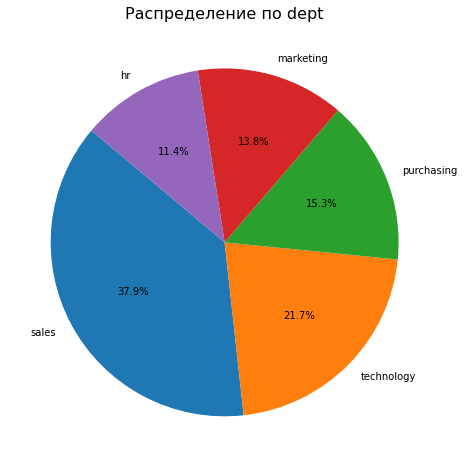

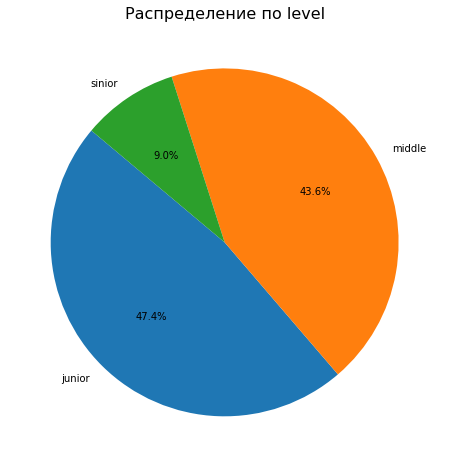

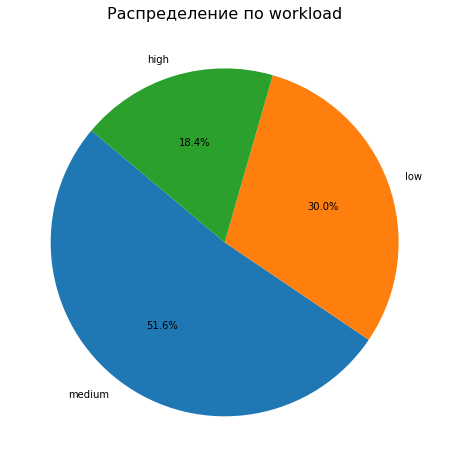

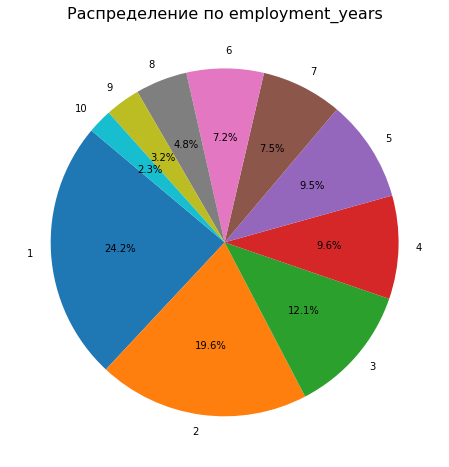

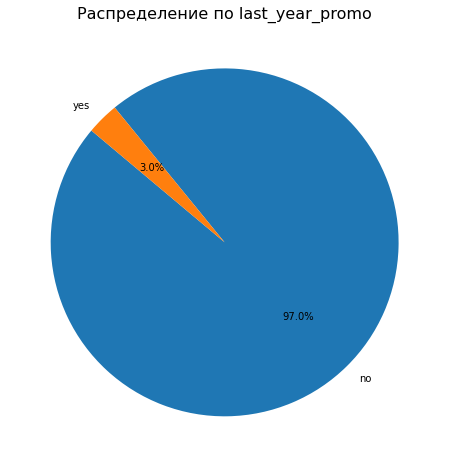

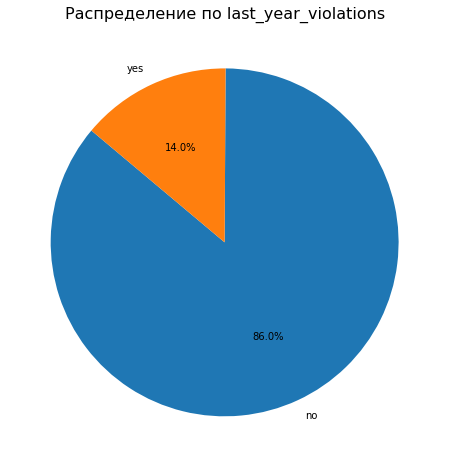

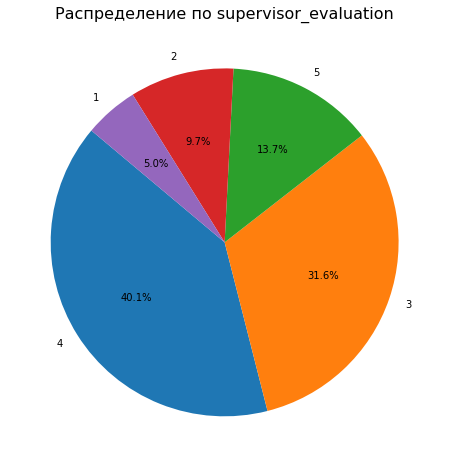

In [21]:
a = ['dept','level','workload','employment_years','last_year_promo','last_year_violations','supervisor_evaluation']

for i in a:
    pivot_pie_chart(df_train,i)

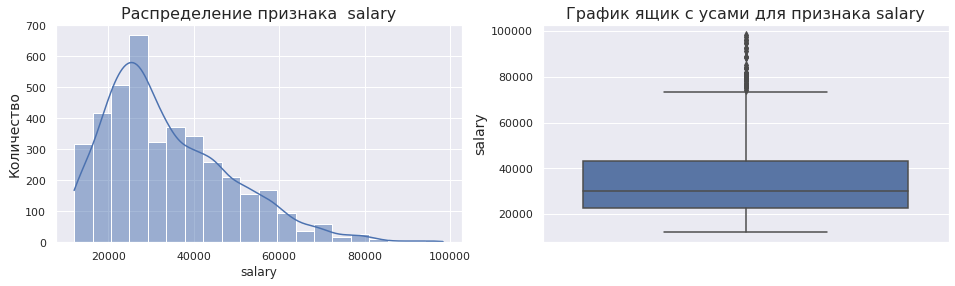

In [22]:
hist_with_wiskers(df_train, 'salary', None)

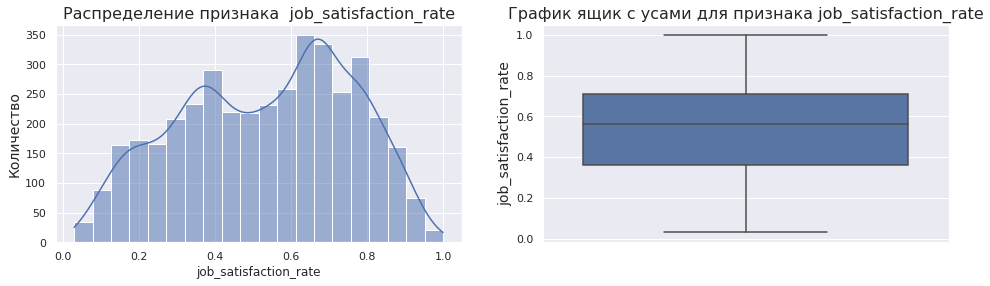

In [23]:
hist_with_wiskers(df_train, 'job_satisfaction_rate', None)

#### Сделаем тоже самое для тестовых данных

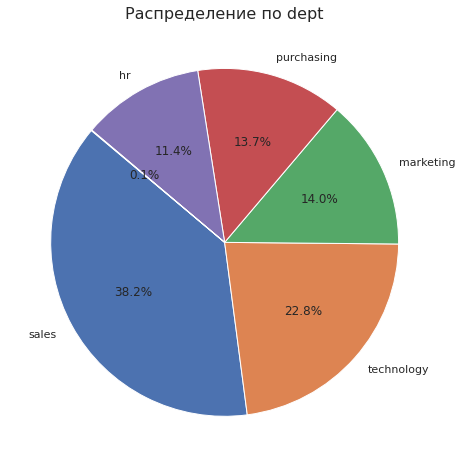

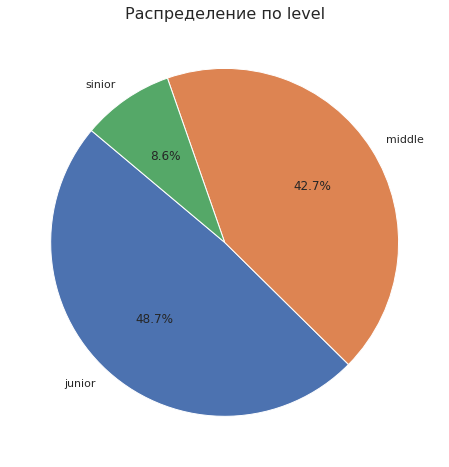

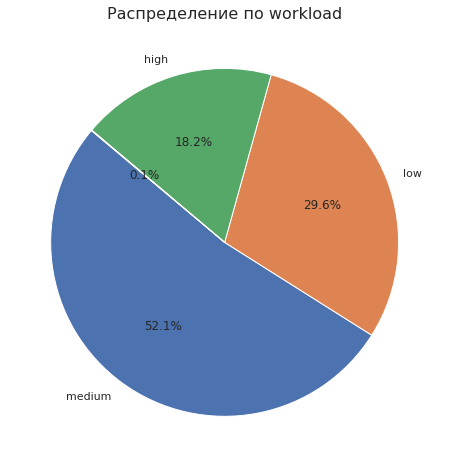

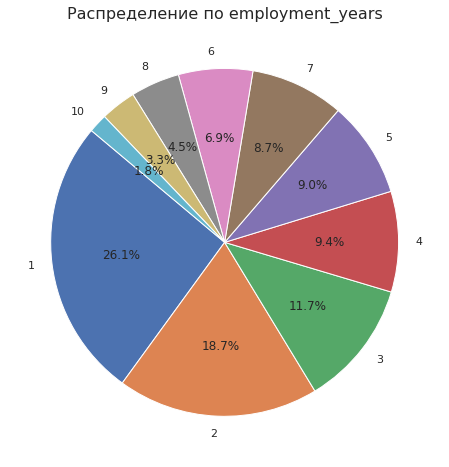

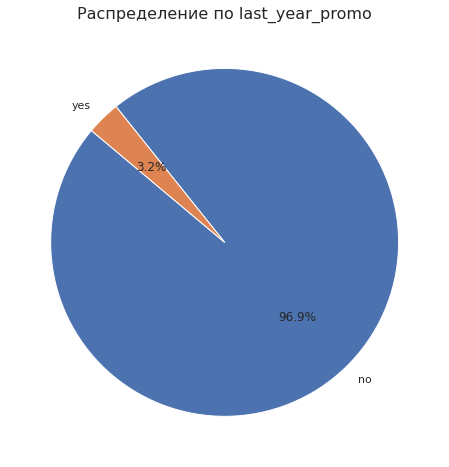

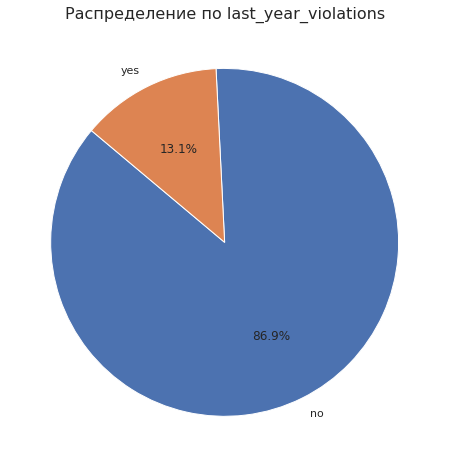

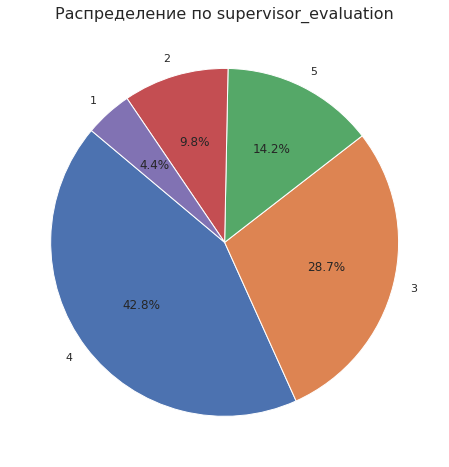

In [24]:
for i in a:
    pivot_pie_chart(X_test,i)

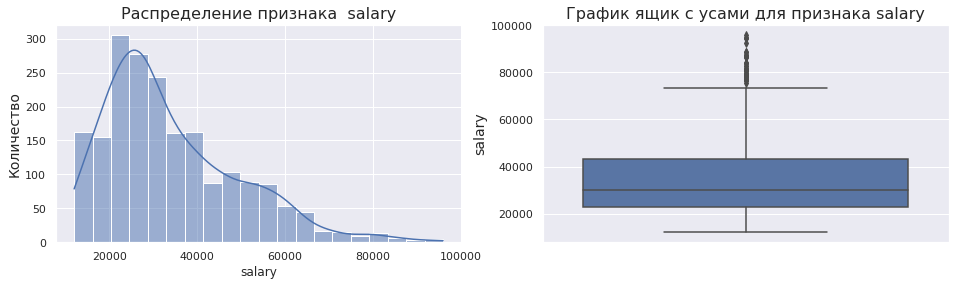

In [25]:
hist_with_wiskers(X_test, 'salary', None)

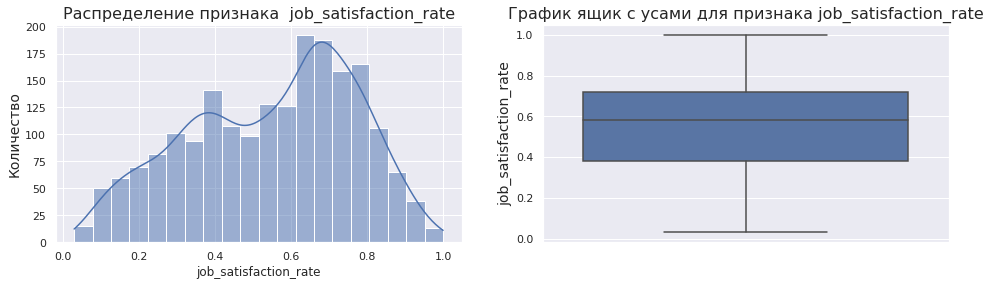

In [26]:
hist_with_wiskers(y_test, 'job_satisfaction_rate', None)

### Вывод по исследовательскому анализу данных.
    1. Графики тренировочных и тестовых выборок похожи, аномальных выбросов не обнаруженно.
    2. Соотношение данных оптимально.
    3. В графиках зарплат есть большие значения, но это обусловленно большой разницой в зарплате джуна и сеньора, при том что джуны в обоих случаях занимают почти половину всей выборки.
    4. Для подготовки данных будем использовать:
        4.1 MinMaxScaler/StandartScaler для стобцов employment_years, salary.
        4.2 OneHotEncoder для столбцов dept, last_year_promo, last_year_violations, level, workload.
        4.3 OrdinalEncoder для столбцов supervisor_evaluation.

### Проведем корреляционный анализ

In [27]:
interval_col=['employment_years','supervisor_evaluation']

def phik_mat(data):
    phik_matrix = data.phik_matrix(verbose=False, interval_cols=interval_col)
    
    mask = np.triu(np.ones_like(phik_matrix, dtype=bool))
    
    plt.figure(figsize=(20, 15))
    sns.heatmap(phik_matrix, annot=True, fmt='.2f', mask=mask)
    plt.title('Корреляционная матрица (Phik)', fontsize=18)
    plt.show()

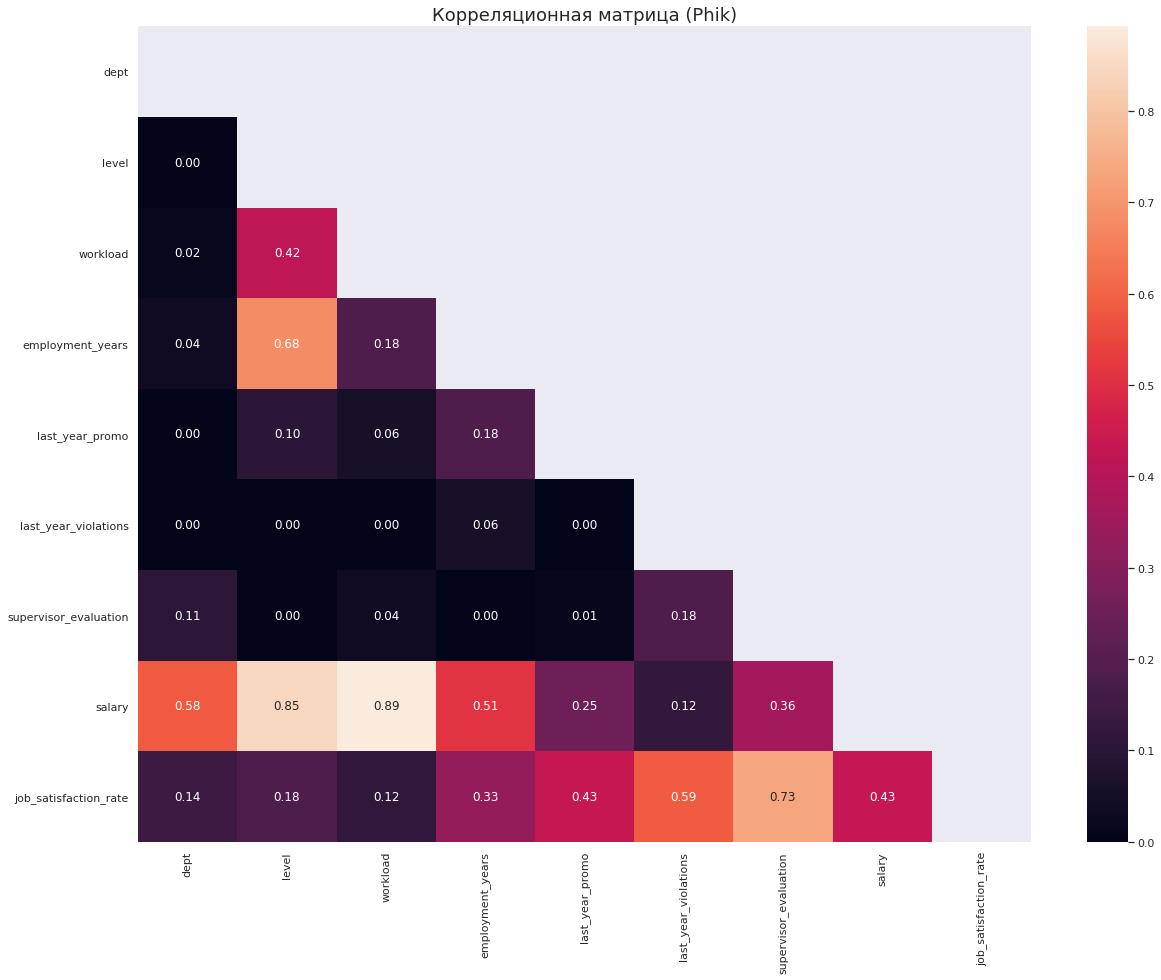

In [28]:
phik_mat(df_train) # Для тренировочных данных

#### Вывод по корреляционному анализу.
    1. Целевой признак job_satisfaction_rate коррелирует сильно коррелирует с признаком, supervisor_evaluation(Оценка руководителя).
    2. Так же есть зависимости с признаками last_year_violations(Нарушения в прошлом году)
    3. С тремя признаками зависимость не очень сильная, (last_year_promo, employment_years, salary)
    4. Мультиколениарности признаков не обнаружено, есть конечно сильная зависимоть в празнакха workload и salary, но значение меньше 0.9 по этому оставим как есть.
    

### Пайплайны.

In [29]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

smape_scorer = make_scorer(smape, greater_is_better=False)

In [30]:
X_train = df_train.drop(['job_satisfaction_rate'], axis=1)
y_train = df_train['job_satisfaction_rate']


In [31]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations', 'level',]
ord_columns = ['level','workload']
num_columns = ['employment_years', 'salary','supervisor_evaluation']

In [32]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
    ]
)

In [33]:
ord_pipe = Pipeline(
     [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories = [['junior', 'middle', 'sinior'], 
                              ['low', 'medium', 'high']],
                handle_unknown='use_encoded_value',
                unknown_value=-1
            ))
     ,('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

In [34]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [35]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [36]:
param_grid = [{'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)]
               ,'models__max_depth': (None, *range(2, 11))
               ,'models__max_features': range(10,18)
               ,'models__min_samples_split':range(2,11)
               ,'models__min_samples_leaf': range(1, 11)
               ,'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},

             {'models': [LinearRegression( )],
              'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [37]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1, 
    error_score='raise')

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations'...
                                         'models__max_features': range(10, 18),
                                         'models__min_samples_leaf': range(1, 11),
                                         'models__min_samples_split': range(2, 11),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False))

In [38]:
print(f'Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print (f'Метрика лучшей модели на кросс-валидации:, {round(-(randomized_search.best_score_),1)}%')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations',
                                                   'level']),
                                

In [39]:
y_test = y_test.sort_index()
X_test = X_test.sort_index()

In [40]:
y_predict = randomized_search.predict(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [41]:
print(f'Метрика SMAPE на тестовых данных равна',smape(np.array(y_test['job_satisfaction_rate']), y_predict))

Метрика SMAPE на тестовых данных равна 13.623751745054244


## Общий вывод для первой задачи:
    1. Лучшая модель по результатам подбора параметров и моделей стала DecisionTreeRegressor с такими параметрами (max_features=13, min_samples_leaf=2, min_samples_split=9, random_state=42).
    2. Данная модель показала себя лучше потому что она лучше отслеживает зависимости не линейных признаков, по сравнению с моделью линейной регрессии.


## Задача 2 Предсказание увольнения сотрудников из компании: 

### Загрузим данные и проведем предобработку если потребуется:

In [42]:
df_train_2 = pd.read_csv('/datasets/train_quit.csv')
# X_test - Данные теже, второй раз загружать и обрабатывать не будем, Так как в X_test они уже обработаны от пропусков.
y_test_2 = pd.read_csv('/datasets/test_target_quit.csv')

In [43]:
data_info(df_train_2)
data_miss(df_train_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


Кол-во пропусков:
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
Кол-во явных дубликатов: 0


,0
id,0.000000
dept,0.000000
level,0.000000
workload,0.000000
employment_years,0.000000
last_year_promo,0.000000
last_year_violations,0.000000
supervisor_evaluation,0.000000
salary,0.000000
quit,0.000000


In [44]:
data_info(y_test_2)
data_miss(y_test_2)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0


Кол-во пропусков:
 id      0
quit    0
dtype: int64
Кол-во явных дубликатов: 0


,0
id,0.000000
quit,0.000000


В данных нет пропусков и дупликатов, проверим уникальные значения.

In [45]:
uniq_df(df_train_2)

id [723290 814010 155091 ... 536432 692133 853842]
dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
employment_years [ 2  5  1  8  4  7  3  9  6 10]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
supervisor_evaluation [4 1 3 5 2]
salary [54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000
 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000
 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600
 87600 75600 91200 76800 74400 80400 85200 86400 92400]
quit ['no' 'yes']


In [46]:
uniq_df(y_test_2)

id [999029 372846 726767 ... 746018 247658 460332]
quit ['yes' 'no']


#### Выводы по загрузке и предобработке данных.
    1. Данные нормальные, ошибок и пропусков нет.

### Проведем исследовательский анализ данных.

In [47]:
df_train_2.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

In [48]:
y_test_2.columns

Index(['id', 'quit'], dtype='object')

In [49]:
df_train_2 = df_train_2.set_index('id')
y_test_2 = y_test_2.set_index('id')

#### Посмотрим на тренировочные данные.

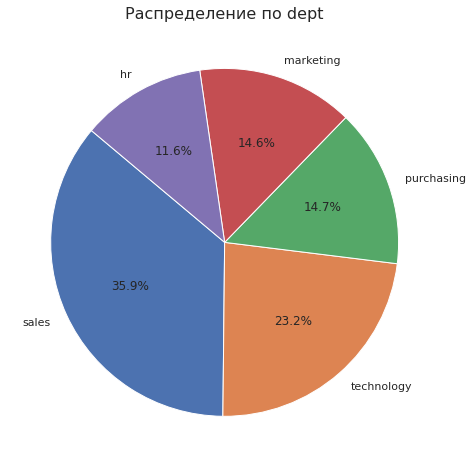

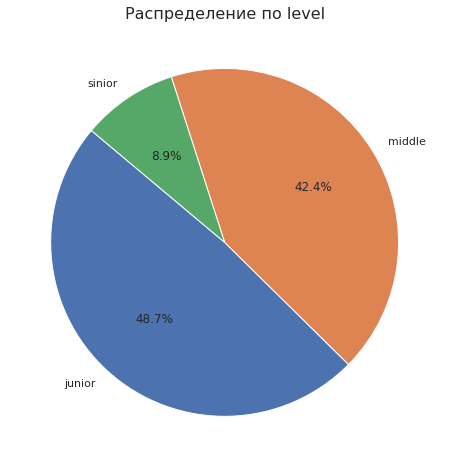

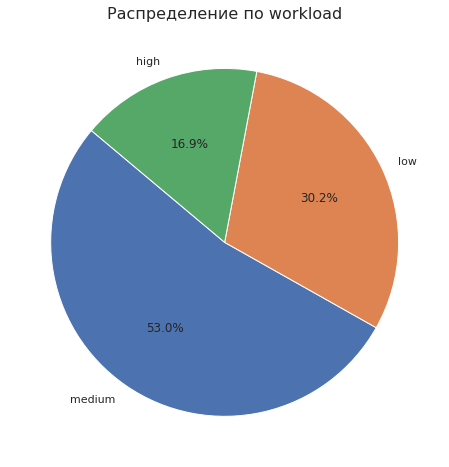

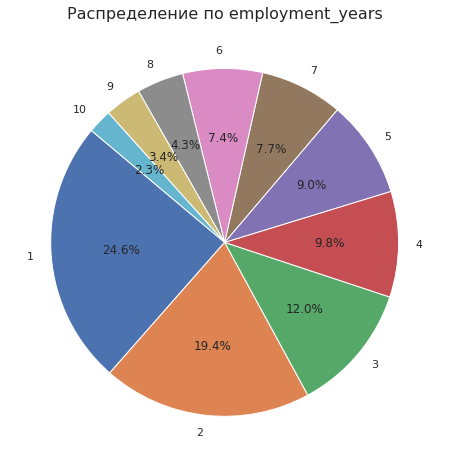

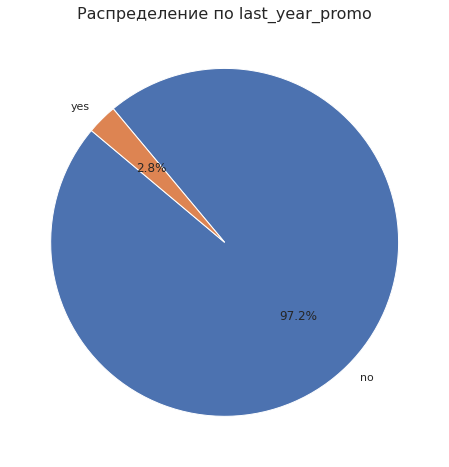

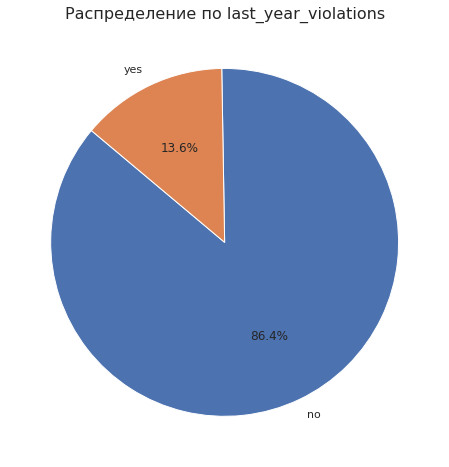

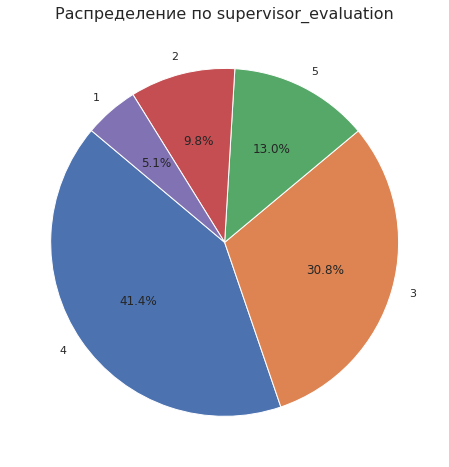

In [50]:
a = ['dept','level','workload','employment_years','last_year_promo','last_year_violations','supervisor_evaluation']

for i in a:
    pivot_pie_chart(df_train_2,i)

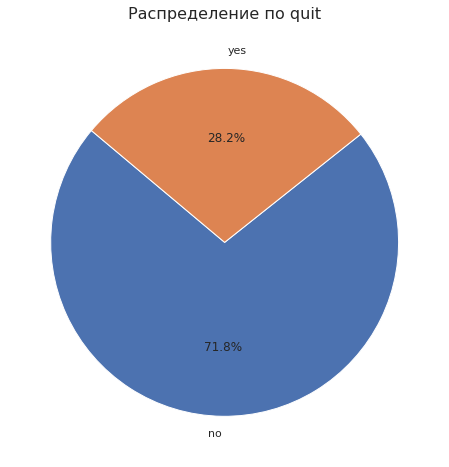

In [51]:
pivot_pie_chart(df_train_2,'quit')

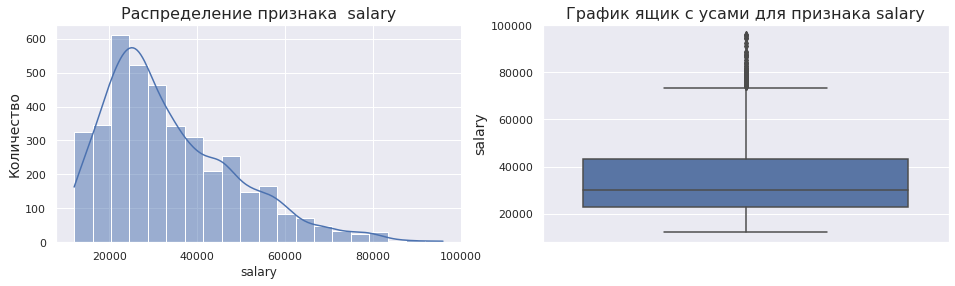

In [52]:
hist_with_wiskers(df_train_2, 'salary', None)

### Построим матрицу корреляции для тренировочных данных.

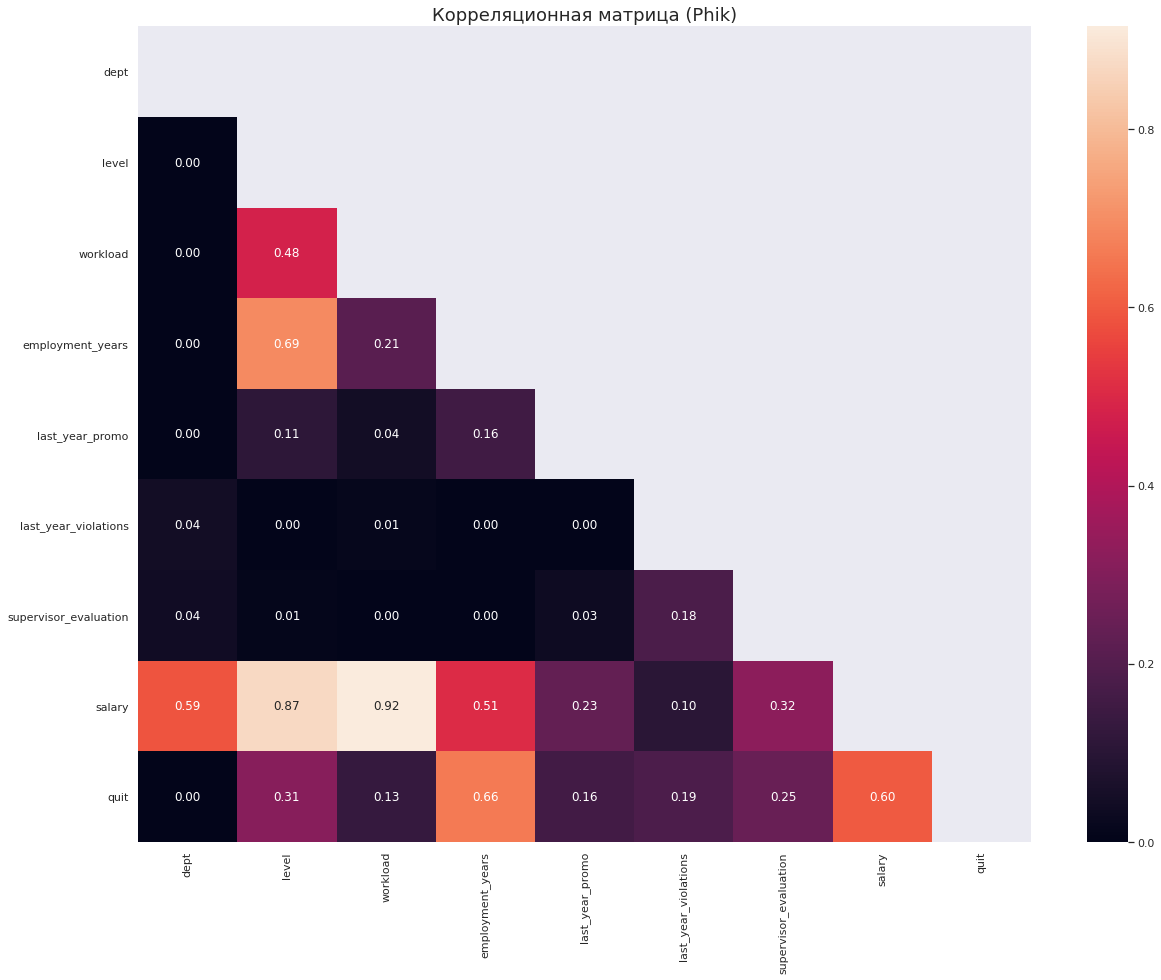

In [53]:
phik_mat(df_train_2)

### Вывод по результам исследовательского анализа: 
    1. Данные распределены нормально, по тренировочным данных видно, что уволилось 28.4% от общего числа сотрудников.
    2. Присутсвует мультколениарность признаков salary и workload, моем убрать один из признаков для улучшения модели.
    3. Увольнение(quit) имеет выраженную зависимость с зарплатой сотрудника, а так же стажем работы в организации.

## Составим портрет уволившегося сотрудника.

In [54]:
a = ['workload','last_year_promo','last_year_violations','salary']

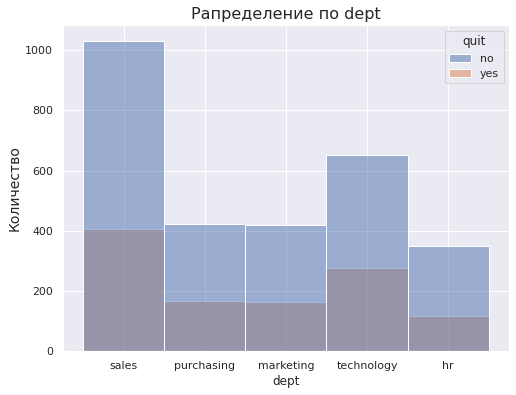

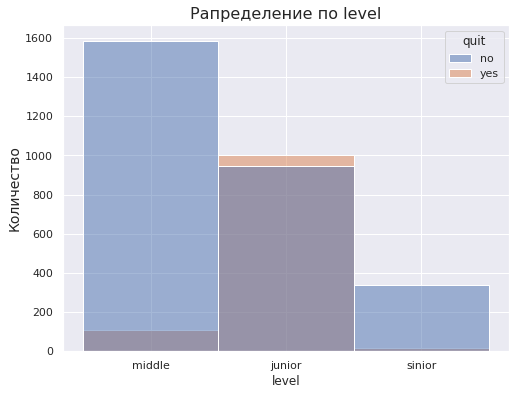

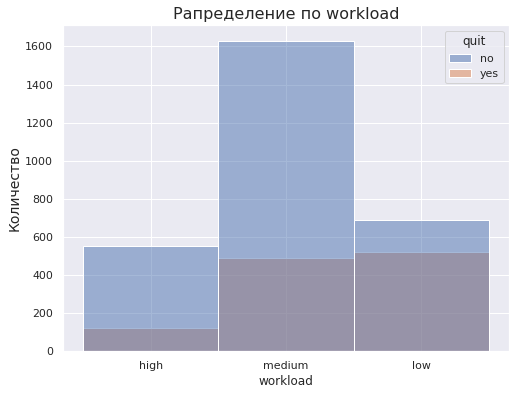

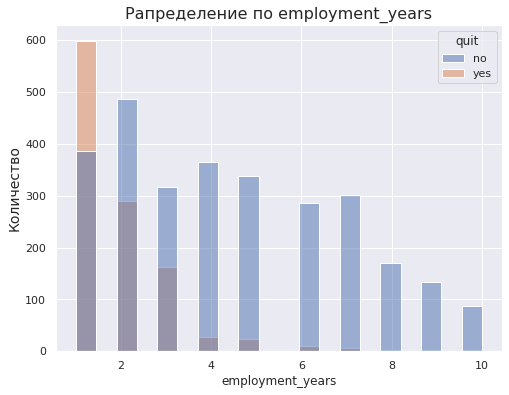

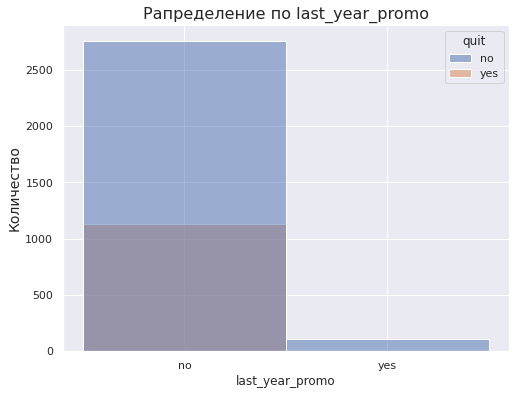

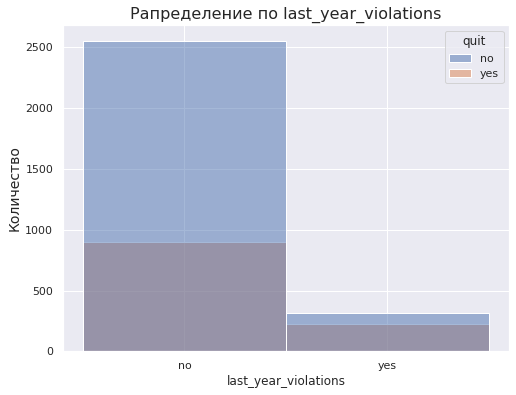

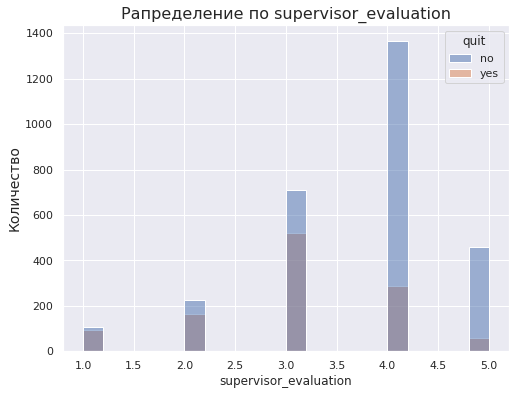

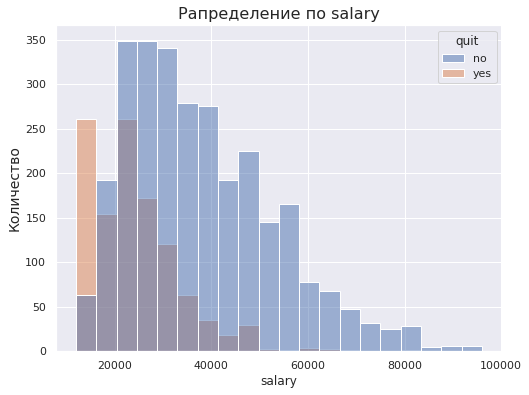

In [55]:
for i in a:
    histogram(df_train_2, i, 'quit')

In [56]:
df_train_2_query = df_train_2.query('quit == "yes"')

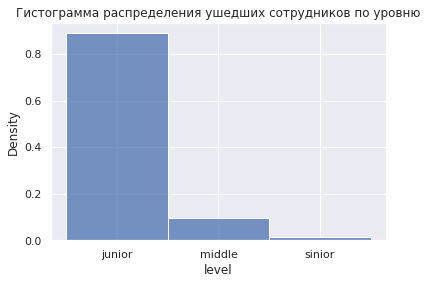

In [57]:
sns.histplot(data=df_train_2_query,x='level',stat='density', common_norm=False)
plt.title('Гистограмма распределения ушедших сотрудников по уровню')
plt.show()

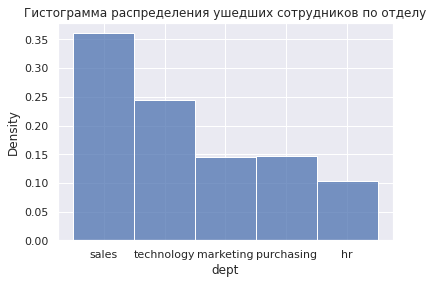

In [58]:
sns.histplot(data=df_train_2_query,x='dept',stat='density', common_norm=False)
plt.title('Гистограмма распределения ушедших сотрудников по отделу')
plt.show()

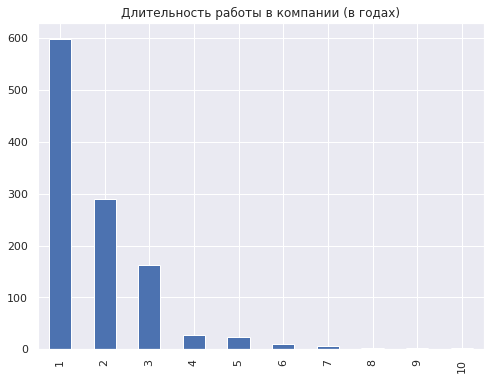

In [59]:
(df_train_2.loc[df_train_2['quit'] == 'yes', 'employment_years']
 .value_counts()
 .plot(y = 'count', kind = 'bar', title = 'Длительность работы в компании (в годах)', figsize=(8,6))
)
plt.show()

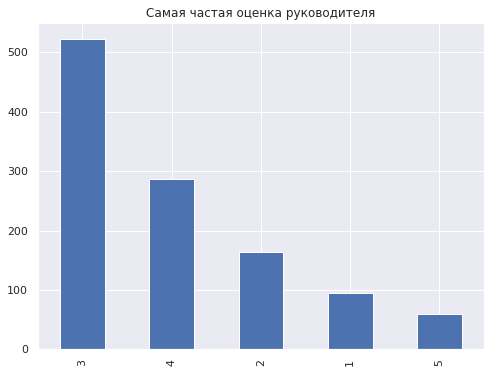

In [60]:
(df_train_2.loc[df_train_2['quit'] == 'yes', 'supervisor_evaluation']
 .value_counts()
 .plot(y = 'count', kind = 'bar', title = 'Самая частая оценка руководителя', figsize=(8,6))
)
plt.show()

#### Портрет уволившегося сотрудника.
    1. Он скорее всего работал либо в отделе продаж(sales) либо в отделе технологии(tecnology)
    2. Находился на junior позиции.
    3. У него была среднняя или низкая загружненность.
    4. Работал не больше 3-х лет.
    5. Не имел повышение в прошлом году.
    6. И оценка руководителя 3 или 4.
    7. Зарплата была 40000 и меньше.

### Визуализируем и сравним распределение признака job_satisfaction_rate с признаков увольнения

In [61]:
y_test_2 = y_test_2.sort_index()
X_test_2 = X_test.sort_index()

In [62]:
test_1 = X_test_2

In [63]:
test_1['job_satisfaction_rate'] = y_test['job_satisfaction_rate']

In [64]:
test_1['quit'] = y_test_2['quit']

In [65]:
test_1

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80,no
100480,marketing,junior,low,4,no,no,4,16800,0.84,no
100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
100610,sales,middle,medium,5,no,no,4,43200,0.75,no
100692,sales,middle,high,6,no,no,4,48000,0.69,no
...,...,...,...,...,...,...,...,...,...,...
997290,sales,sinior,medium,7,no,no,4,58800,0.79,no
998548,marketing,junior,medium,2,no,no,4,32400,0.76,yes
998762,technology,junior,low,3,no,no,3,22800,0.48,yes


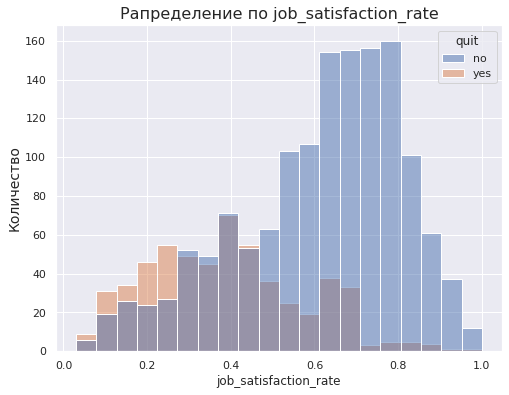

In [66]:
histogram(test_1, 'job_satisfaction_rate', 'quit')

### Выводы по графику распределения:
    1. Судя по гистограммам дейтсвительно те кто уволились, были низко удовлетворены работой, пик приходится на 0.4, а те кто продолжают рабатать, удовлетворены работой от 0.6 до 0.9 в пике.

### Добавим новый признак на основе предсказаний прошлой задачи.

In [67]:
X_train_2 = df_train_2.drop(['quit'], axis=1)
y_train_2 = df_train_2['quit']

In [68]:
X_train_2['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(X_train_2)
X_test_2 = X_test
X_test_2['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(X_test_2)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [69]:
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary', 'job_satisfaction_rate']

In [70]:
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [71]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_2, y_train_2)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations',
                                                                                'level']),
                                                                              ('ord',
                                                                               Pipelin...
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [DecisionTreeClassifier(max_depth=6,
                                                                           max_features=9,
                                                                           random_state=42)],
                                         'models__max_depth': range(2, 11),
                                         'models__max_features': range(2, 11),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [72]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations',
                                                   'level']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befo...
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years', 'salary',
                                                   'supervisor_evaluation'])])),
                ('models',
                 DecisionTreeClassifier(max_depth=6, max_features=9,
                                        random_state=42))])

In [73]:
randomized_search.best_score_

0.9264174467624471

In [74]:
y_predict_proba = randomized_search.predict_proba(X_test_2)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [75]:
roc_auc_score(y_test_2, y_predict_proba[:, 1])

0.9228001096426243

### Промежуточные выводы:
    1. После обучения модели лучше моделью стала DecisionTreeClassifier(max_depth=6, max_features=9, random_state=42).
    2. метрика ROC_AUC 0.9228, что подходит по условию задачи, так как нам требуется более 0.91
    3. Данная модель справилась лучше, так как она более лучше улавливает зависимости признаков, при отсутсвии линейной зависимости.

## Итоговые выводы:
### Описание задачи:
1. Целью работы было оптимизирование управлением персоналом компании «Работа с заботой» по данным HR-аналитиков.
2. Нужно было определить степень удовлетворенности сотрудников работой, и выявить причины их недовольства, а так причину их вероятного ухода.
3. Создание модели для предсказания вероятного ухода сотрудников в последующем.
### Описание этапов работ:
1. Первым этам была загрузка библиотек и загрузка данных, задача была разделена на два задания.
    1. Первой задачей была оценка удовлетворенности сотрудников компании, я загрузил данные, проверил их на явные и не явные дупликаты, построил графики взаимосвязи целевого признака(job_satisfaction_rate) в вводными признаками из данных предоставленных HR-аналитиками. Построил корреляционную матрицу, для выявления мультиколениарности, а так же для оценки зависимостей целевого признака от входных.
    2. Далее был создан пайплайн, для подбора гипперпараметров и упрощения работы, также была создана метрика, для оценки качества лучше модели.
    3. Модель была проверена на тестовых данных и показала хороший результат.
2. Второй задачей была создание модели для предлсказания возмонжого увольнения сторудника.
    1. Я загрузил новвые данные, изучил их, проверил на дупликаты.
    2. Далее провел исследовательский анализ этих данных, построил графики, для оценки признаков, а так же графики для оценки взаимосвязи целевого признака(quit) c входными признаками.
    3. Построил матрицу кореляции для оценки взаимосвязей, а так же выявления мультиколениарности.
    4. На основе работы лучше модели из прошлой задачи, добавил признак удовлетворенность работой(job_satisfaction_rate), в входные признаки.
    5. Создал новый список с параметрами для новой модели, применил их, для выявления лучше модели для предсказания целевого признака quit.
    6. Метрийкой ROC_AUC(Так как она хороше подходит для определения отношения признака к определенной категории) оценил работу лучшей модели.
### Основные выводы по разделам можно посмотреть по ссылкам ниже:
1. [Выводы по загрузке и исследованию данных первой задачи](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/a3b53506-2eab-48b4-ae1d-a4094f86272f.ipynb#Вывод-по-загрузке-и-просмотру-данных.)
2. [Выводы по предобработке данных первой задачи](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/a3b53506-2eab-48b4-ae1d-a4094f86272f.ipynb#Вывод-по-предобработке-данных.)
3. [Выводы по исследовательскому анализу данных первой задачи](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/a3b53506-2eab-48b4-ae1d-a4094f86272f.ipynb#Вывод-по-исследовательскому-анализу-данных.)
4. [Выводы по корреляционному анализу первой задачи](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/a3b53506-2eab-48b4-ae1d-a4094f86272f.ipynb#Вывод-по-корреляционному-анализу.)
5. [Общий вывод для первой задачи](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/a3b53506-2eab-48b4-ae1d-a4094f86272f.ipynb#Общий-вывод-для-первой-задачи:)
6. [Выводы по загрузке и предобработке данных второй задачи](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/a3b53506-2eab-48b4-ae1d-a4094f86272f.ipynb#Выводы-по-загрузке-и-предобработке-данных.)
7. [Выводы по результатам исследовательского анализа второй задачи](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/a3b53506-2eab-48b4-ae1d-a4094f86272f.ipynb#Вывод-по-результам-исследовательского-анализа:)
8. [Портрет уволившегося сотрудника](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/a3b53506-2eab-48b4-ae1d-a4094f86272f.ipynb#Портрет-уволившегося-сотрудника.)
9. [Выводы по взаимосзязи удовлетвореннойстью сотрудника работой, с увольнением.](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/a3b53506-2eab-48b4-ae1d-a4094f86272f.ipynb#Выводы-по-графику-распределения:)
10. [Итоговые выводы](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/a3b53506-2eab-48b4-ae1d-a4094f86272f.ipynb#Итоговые-выводы:)

### Итоговы Выводы и рекомендации для бизнеса:
    1. Согласно данным больше всего сотрудников увольняется из отделов salery и tecnology следует провести дополнительную работу с данными отделами, с целью повышения их мотивации остаться в компании. Возможно проводить корпоративные тренинги, повышение премиальной части, так как эти отделы напрямую работаю с клиентами компании.
    2. Больше всего уволившихся это работники которые работают меньше 3-х лет, и были на позиции junior, то есть новички. При этом чаще всего у них не было повышения в работе за прошлый год, следовательно и доход не вырос. Следует лучше мотивировать начинающих специалистов, оставатся на одном месте, возможно давать им более высокую нагрузгу, с дополнительными выплатами. 
    3. Так же руководители достаточно низко оценивают новичков, следует провести работу с непосредственными руководителями, что бы они не сравнивали новичков с уже устоявшимися коллегами. Для молодого специалиста важна хорошая оценка своего начальника, пусть она будет и немного преувеличиной, это будет больше мотивировать на развитие в компании.
    4. Уволившиеся сотрудники, чаще всего не довольны своей зарплатой, как я уже писал выше, возможно данным сотрудникам следует дать дополнительную мотивацию, в ввиде корпоротивных выездов, тренингов, отправки на дополнительные курсы, на направления нужные компании, с целью развития данного сотрудника как специалиста для того, что бы сотрудник видел возможности роста как карьерного, так и финансового. 